In [1]:
import torch
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

## 查看資料

In [2]:
train_df = pd.read_csv('../train.csv')
train_df.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952


In [3]:
train_df.describe()

,Open Price,Close Price,High Price,Low Price,Volume
count,2264.000000,2264.000000,2264.000000,2264.000000,2.264000e+03
mean,1656.142686,1656.767562,1664.427054,1647.425128,2.948755e+09
std,485.292193,485.226120,484.808706,485.576116,1.351675e+09
min,679.280000,676.530000,695.270000,666.790000,5.181584e+08
25%,1238.602500,1239.337500,1246.695000,1227.587500,2.048980e+09
50%,1649.135000,1650.405000,1656.145000,1639.600000,2.506637e+09
75%,2070.300000,2071.190000,2079.507500,2058.757500,3.373334e+09
max,2692.710000,2690.160000,2694.970000,2685.920000,9.120100e+09


確認是否有缺值，發現該有的資料都有

In [4]:
train_df.isnull().sum()

Date           0
Open Price     0
Close Price    0
High Price     0
Low Price      0
Volume         0
dtype: int64

觀察前一百比資料開盤價、收盤價、當天的開盤與收盤價差

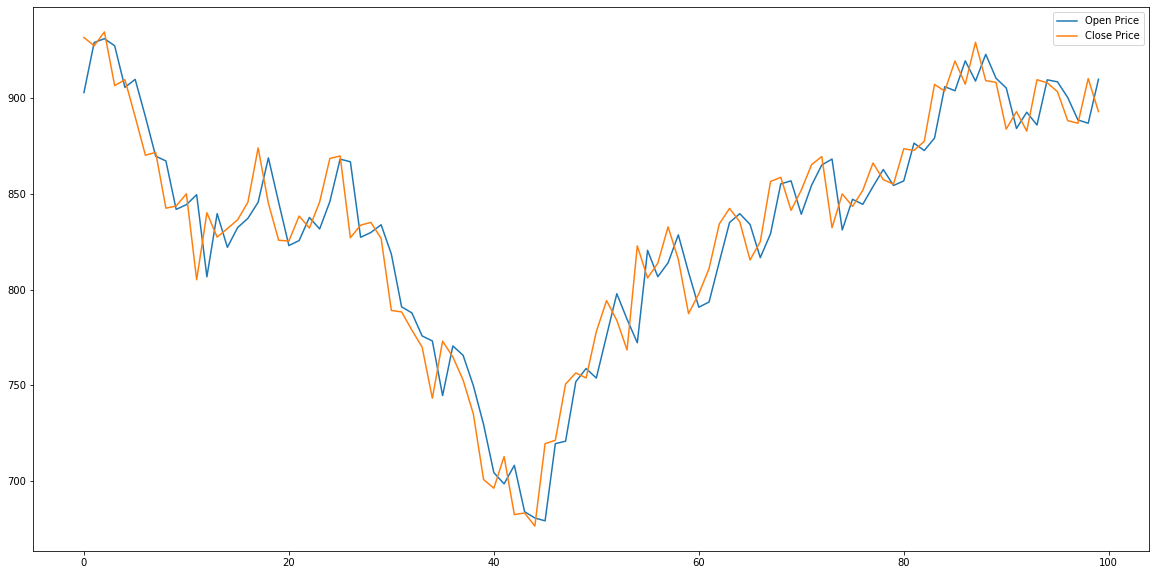

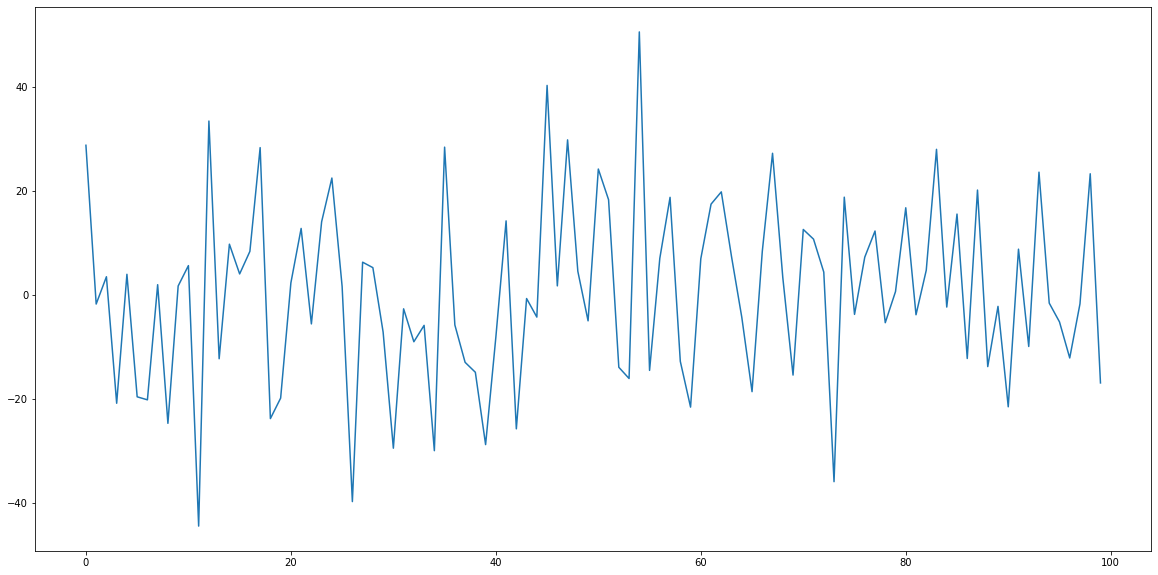

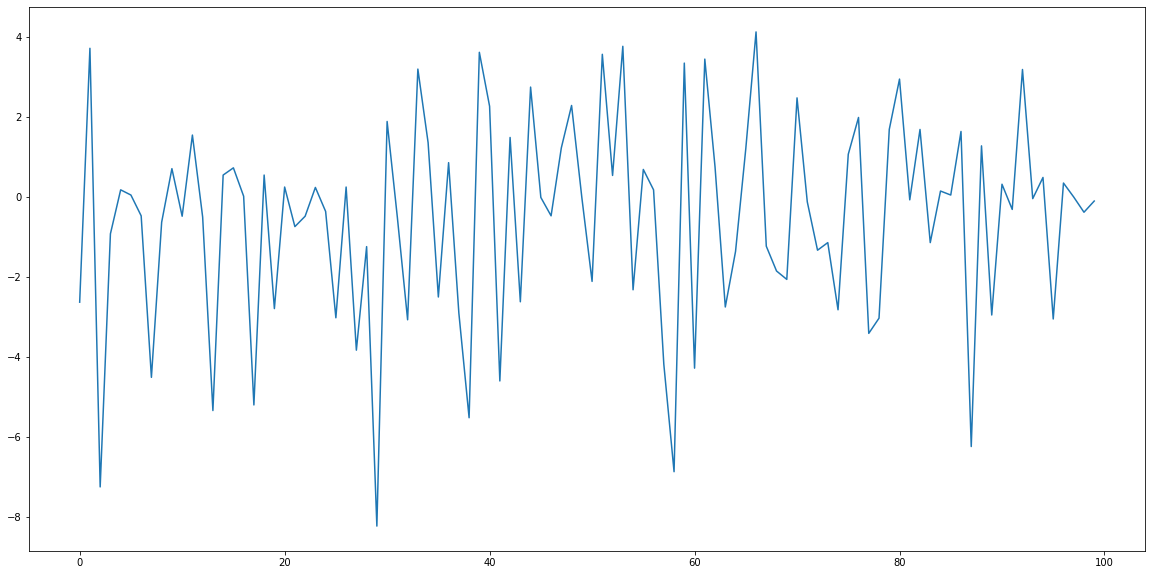

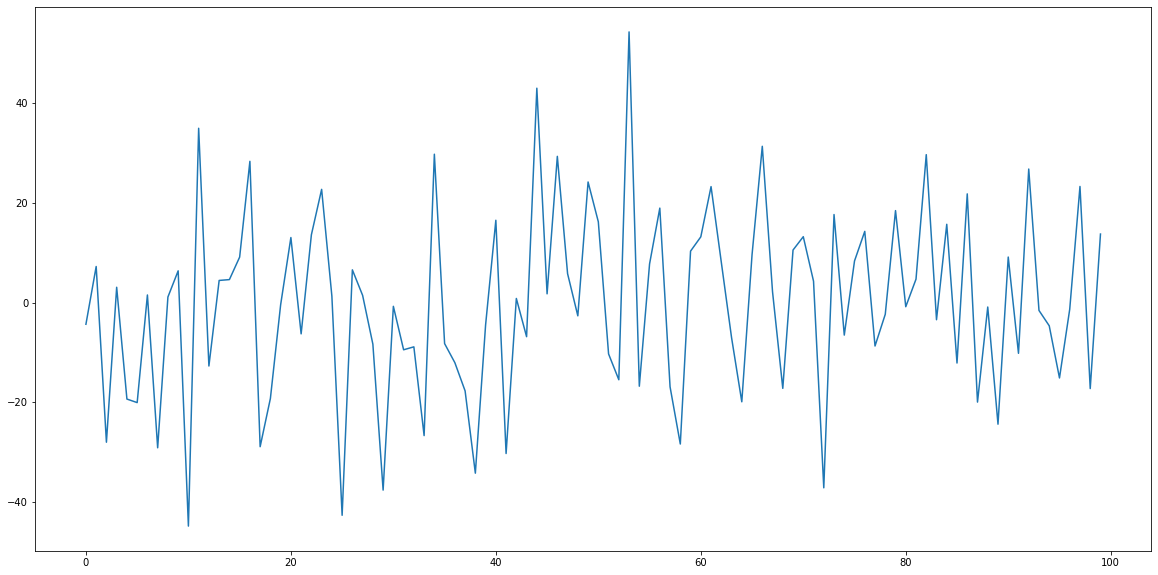

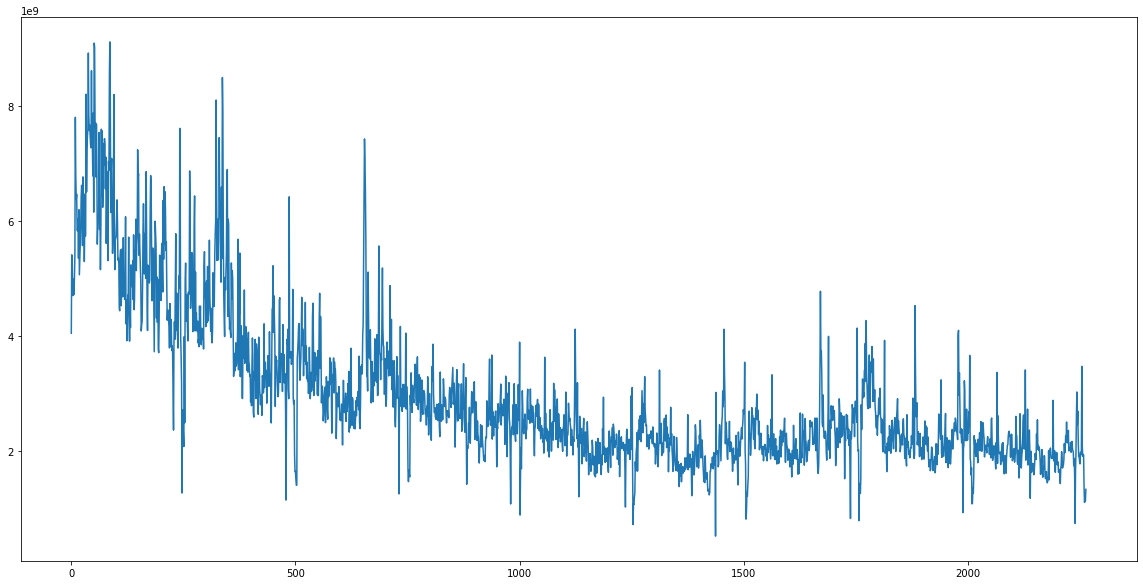

In [5]:
plt.figure(figsize=(20,10))

plt.plot(range(100), train_df['Open Price'][:100], label='Open Price')
plt.plot(range(100), train_df['Close Price'][:100], label='Close Price')
plt.legend()


tmp = train_df['Close Price'] - train_df['Open Price']
plt.figure(figsize=(20,10))
tmp[:100].plot();

plt.figure(figsize=(20, 10))
plt.plot(range(100), [i - j for (i, j) in zip(train_df['Open Price'][1:101], train_df['Close Price'][:100])])

plt.figure(figsize=(20, 10))
plt.plot(range(100), [i - j for (i, j) in zip(train_df['Close Price'][1:101], train_df['Close Price'][:100])])

plt.figure(figsize=(20, 10))
plt.plot(range(len(train_df['Volume'])), train_df['Volume'])

看看當天的 **High Price** 與 **Open Price** 之間的落差與當天漲或停的趨勢

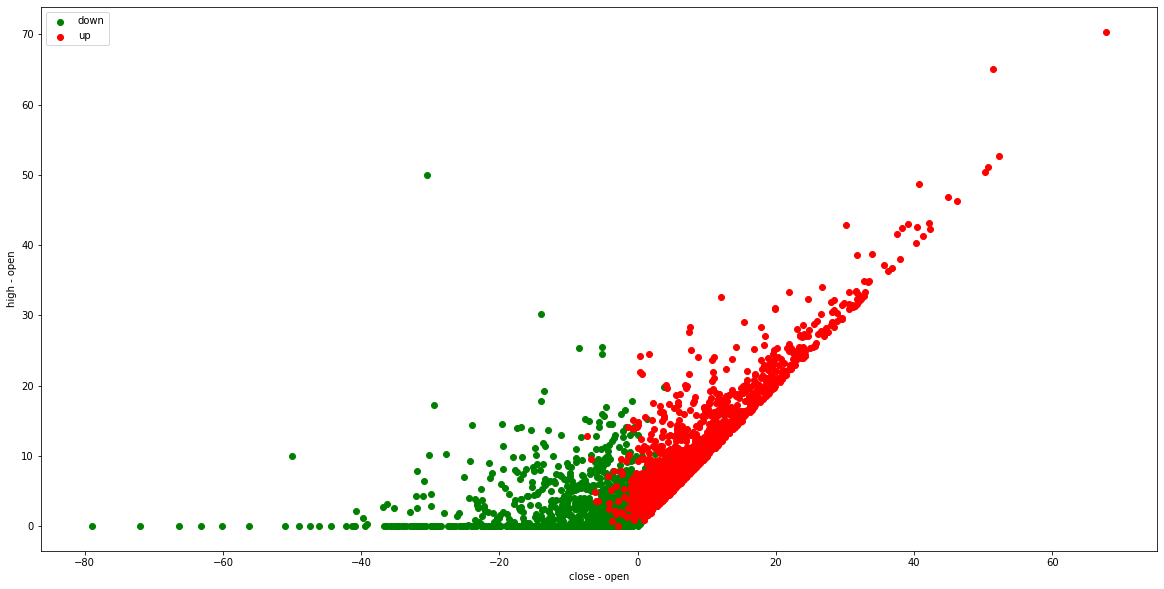

In [6]:
plt.figure(figsize=(20,10))

x = train_df['Close Price'][1:] - train_df['Open Price'][1:]
y = train_df['High Price'][1:] - train_df['Open Price'][1:]

predict = [ 1 if (train_df['Close Price'][i+1] - train_df['Close Price'][i]) > 0 else 0 for i in range(len(train_df['High Price']) - 1)]

x1 = [ i for (i, j) in zip(x, predict)  if j == 0 ]
y1 = [ i for (i, j) in zip(y, predict)  if j == 0 ]
x2 = [ i for (i, j) in zip(x, predict)  if j == 1 ]
y2 = [ i for (i, j) in zip(y, predict)  if j == 1 ]


plt.scatter(x1, y1, c='g', label='down')  
plt.scatter(x2, y2, c='r', label='up')
plt.xlabel('close - open')
plt.ylabel('high - open')
plt.legend()
plt.show()  

由下圖可以發現跌幅越大，當天收盤是跌的機率越高

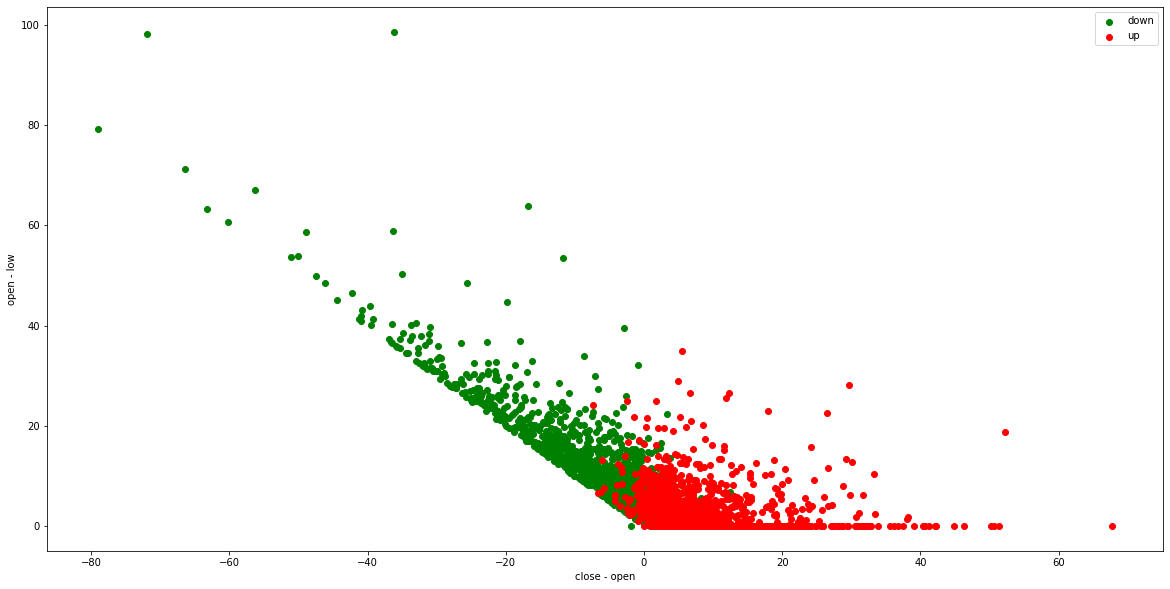

In [7]:
plt.figure(figsize=(20,10))

x = train_df['Close Price'][1:] - train_df['Open Price'][1:]
y = train_df['Open Price'][1:] - train_df['Low Price'][1:]

predict = [ 1 if (train_df['Close Price'][i+1] - train_df['Close Price'][i]) > 0 else 0 for i in range(len(train_df['High Price']) - 1)]

x1 = [ i for (i, j) in zip(x, predict)  if j == 0 ]
y1 = [ i for (i, j) in zip(y, predict)  if j == 0 ]
x2 = [ i for (i, j) in zip(x, predict)  if j == 1 ]
y2 = [ i for (i, j) in zip(y, predict)  if j == 1 ]


plt.scatter(x1, y1, c='g', label='down')  
plt.scatter(x2, y2, c='r', label='up')
plt.xlabel('close - open')
plt.ylabel('open - low')
plt.legend()
plt.show()  

### Preprocess

由上面可以發現，Open Price, Close Price 等等的實際數量不大重要，重要的是當中的變化，
<br>
因此決定使用以下作為 input:
- **Close - Open**: 當日收盤與開盤時的數值差
- **High - Open**: 當日高點與開盤時的數值差
- **Open - Low**: 當日低點與開盤時的數值差

In [9]:
from sklearn.model_selection import train_test_split
X = pd.DataFrame({
    'Close - Open': train_df['Close Price'][1:] - train_df['Open Price'][1:],
    'High - Open': train_df['High Price'][1:] - train_df['Open Price'][1:],
    'Open - Low': train_df['Open Price'][1:] - train_df['Low Price'][1:],
})
y = [ 1 if (train_df['Close Price'][i+1] - train_df['Close Price'][i]) > 0 else 0 for i in range(len(train_df['Close Price']) - 1)]

### 訓練 model

使用 1/3 的數值當作 validation set

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.33, random_state=20)

#### logistic regression

使用 **logistic regression** 這個 model，
在 validation set 中的正確率約為 **93%**

In [11]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_val)
clf.score(X_val, y_val)

print(clf.score(X_val, y_val))

0.92904953145917


使用 **confusion matrix** 查看預測結果
發現滿平均的

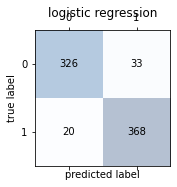

In [12]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_val, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('predicted label')        
plt.ylabel('true label')
plt.title('logistic regression')
plt.show()

`紅色`的部分為預測錯誤
`綠色`的部分為預測正確
可以明顯的發現錯誤都集中在開盤價與收盤價差不多的位置

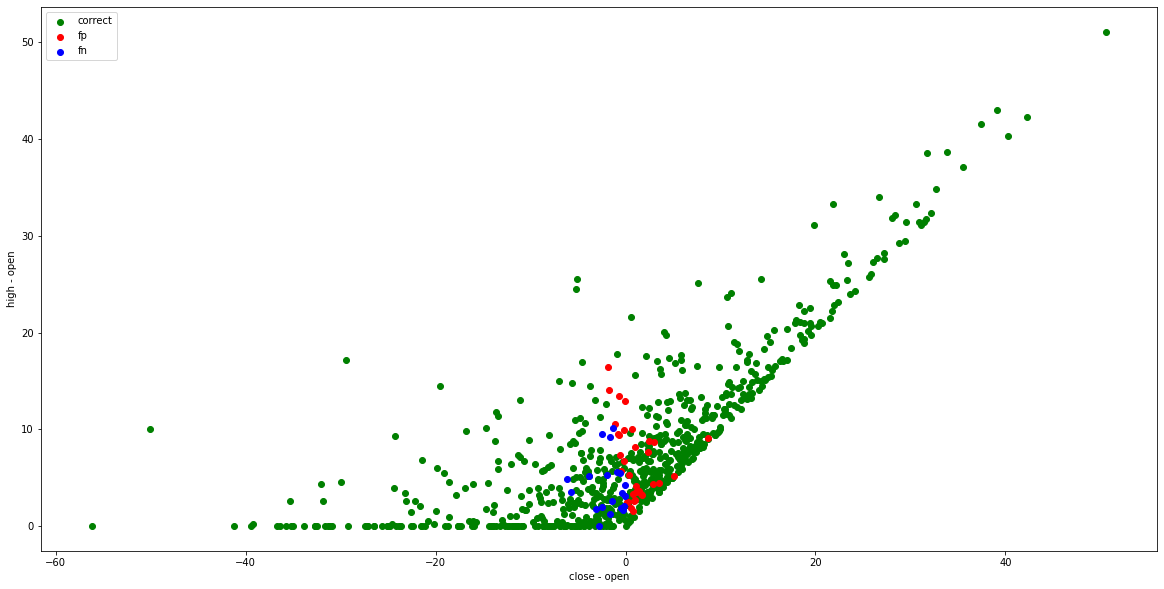

In [13]:
plt.figure(figsize=(20,10))

x = X_val['Close - Open']
y = X_val['High - Open']

x1 = [ i for (i, j, k) in zip(x, y_val, y_pred) if j == k ]
y1 = [ i for (i, j, k) in zip(y, y_val, y_pred) if j == k ]
x2 = [ i for (i, j, k) in zip(x, y_val, y_pred)  if j != k and k==1]
y2 = [ i for (i, j, k) in zip(y, y_val, y_pred)  if j != k and k==1]
x3 = [ i for (i, j, k) in zip(x, y_val, y_pred)  if j != k and k==0]
y3 = [ i for (i, j, k) in zip(y, y_val, y_pred)  if j != k and k==0]


plt.scatter(x1, y1, c='g', label='correct')  
plt.scatter(x2, y2, c='r', label='fp')
plt.scatter(x3, y3, c='b', label='fn')
plt.xlabel('close - open')
plt.ylabel('high - open')
plt.legend()
plt.show()  

#### Other Classfier
在這裡我使用之前使用過的 desition tree 與其變化型
發現正確率與上面的差不多

0.92904953145917


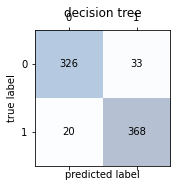

0.92904953145917


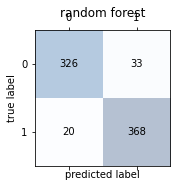

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classifier = [ 
    ('decision tree', DecisionTreeClassifier), 
    ('random forest', RandomForestClassifier)]
other_models = []

for model_name, model in classifier:
    model = DecisionTreeClassifier(random_state=20).fit(X_train, y_train)
    other_models.append(model)
    y_pred = clf.predict(X_val)
    clf.score(X_val, y_val)

    print(clf.score(X_val, y_val))
    
    confmat = confusion_matrix(y_true=y_val, y_pred=y_pred)
    fig, ax = plt.subplots(figsize=(2.5, 2.5))

    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
    plt.title(model_name)
    plt.xlabel('predicted label')        
    plt.ylabel('true label')
    plt.show()

#### Neural Network

In [15]:
from torch.utils.data import Dataset             # 匯入資料集 base class

class MyDataset(Dataset):                        # 繼承 base class 創造資料集
    def __init__(self, data):                    # 給予資料
        self.data = data

    def __len__(self):
        return len(self.data)                    # 定義總資料數

    def __getitem__(self, index):                # 定義取出單一資料的方法
        return torch.tensor(self.data[index])
    
tmp = [ (X_train['Close - Open'].tolist()[i], X_train['High - Open'].tolist()[i], X_train['Open - Low'].tolist()[i], y_train[i]) for i in range(len(y_train))]
train_dataset = MyDataset(tmp)

tmp = [ (X_val['Close - Open'].tolist()[i], X_val['High - Open'].tolist()[i], X_val['Open - Low'].tolist()[i], y_val[i]) for i in range(len(y_val))]
val_dataset = MyDataset(tmp)

In [17]:
from torch.utils.data import DataLoader # 匯入資料集抽樣工具

def collate_fn(batch):                  # 定義格式化的方法
    x_list = []
    y_list = []
    
    for [x1, x2, x3, y] in batch:
        x_list.append([x1, x2, x3])             
        y_list.append([y])                       
    
    return [torch.tensor(x_list).float(),
            torch.tensor(y_list).float()]

In [18]:
# 建立模型

import torch.nn as nn                   # 匯入神經網路模型
import torch.nn.functional as F         # 匯入激發函數

class MyModel(nn.Module):               # 模型需要繼承自 nn.Module
    def __init__(self,                  # 定義模型結構
                 in_dim,                # 定義輸入層維度
                 hid_dim,               # 定義隱藏層維度
                 out_dim):              # 定義輸出層維度

        super(MyModel, self).__init__() # 繼承 nn.Module 所有屬性
        
        self.layer1 = nn.Linear(        # 創造線性層 self.layer1
            in_features=in_dim,         # 設定線性層輸入維度
            out_features=hid_dim        # 設定線性層輸出維度
        )
        self.layer2 = nn.Linear(        # 創造線性層 self.layer2
            in_features=hid_dim,        # 設定線性層輸入維度
            out_features=out_dim        # 設定線性層輸出維度
        ) 
        
    def forward(self, batch_x):         # 定義運算流程
        h = self.layer1(batch_x)        # 使用線性層 self.layer1 輸入 batch_x 計算得到 h
        a = F.softmax(h)                # 使用 softmax 激發函數輸入 h 得到 a
        y = self.layer2(a)              # 使用線性層 self.layer2 輸入 a 計算得到 y
        return y                        # 輸出 y


In [30]:
from torch.optim import SGD             # 匯入計算梯度下降演算法的工具
from torch.optim import Adam

# 驗證
if torch.cuda.is_available():                   # 如果有可用 GPU 時採用 GPU cuda:0
    device = torch.device('cuda:0')
else:                                           # 若無 GPU 可用則使用 CPU
    device = torch.device('cpu')

# 設定超參數

batch_size = 16                         # 設定每次抽樣的數量
n_epoch = 10                            # 設定資料集總訓練次數
hid_dim = 20                            # 設定隱藏層維度

train_data_loader = DataLoader(         # 創造 DataLoader 實例
    train_dataset,                      # 對資料集 train_dataset 進行抽樣
    batch_size=batch_size,              # 設定每次抽樣的數量
    shuffle=True,                       # 設定隨機抽樣
    collate_fn=collate_fn               # 指定格式化的方法
)
test_data_loader = DataLoader(          # 創造 DataLoader 實例
    val_dataset,                        # 對資料集 test_dataset 進行抽樣
    batch_size=batch_size,              # 設定每次抽樣的數量
    shuffle=True,                       # 設定隨機抽樣
    collate_fn=collate_fn               # 指定格式化的方法
)

model = MyModel(                        # 創造 MyModel 模型實例
    in_dim=3,                           # 設定輸入層維度
    hid_dim=hid_dim,                    # 設定隱藏層維度
    out_dim=1                           # 設定輸出層維度
)
model = model.to(device)                # 將模型搬移至 GPU

criterion = nn.MSELoss()                # 創造均方誤差計算工具

optimizer = SGD(                        # 創造計算隨機梯度下降的工具
    model.parameters(),                 # 設定計算梯度下降的目標
    lr=0.0001                           # 設定學習率
)

for epoch in range(n_epoch):            # 總共訓練 n_epoch 次
    for batch_x, batch_y in train_data_loader:
        batch_x = batch_x.to(device)    # 將訓練資料搬移至 GPU
        batch_y = batch_y.to(device)    # 將訓練資料標記搬移至 GPU
        
        pred_y = model(batch_x.float())     # 自動呼叫 forward 計算 batch_x 得到 pred_y
        loss = criterion(pred_y,            # 計算 pred_y 與 batch_y 的均方誤差
                         batch_y.float())
        
        loss.backward()                 # 使用向後傳播計算梯度
        optimizer.step()                # 使用梯度下降更新模型參數
    
    with torch.no_grad():               # 此區塊不會計算梯度
        total_loss = 0                  # 統計訓練資料誤差
        for batch_x, batch_y in train_data_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            pred_y = model(batch_x)
            loss = criterion(pred_y, batch_y)
            
            total_loss += float(loss) / len(train_data_loader)
        
        print('Epoch {}, training loss: {}'.format(epoch, total_loss))
        
        total_loss = 0                  # 統計測試資料誤差
        for batch_x, batch_y in test_data_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            pred_y = model(batch_x.float())
            loss = criterion(pred_y, batch_y)
            
            total_loss += float(loss) / len(test_data_loader)
            
        print('Epoch {}, testing loss: {}'.format(epoch, total_loss))

/Users/0210amy/Desktop/school/schoolwork/data_analystic/FDA_HW3/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0, training loss: 0.17436214105079045
Epoch 0, testing loss: 0.1797935227130322
Epoch 1, training loss: 0.2573018655965203
Epoch 1, testing loss: 0.2745695875046101
Epoch 2, training loss: 0.13303792484496765
Epoch 2, testing loss: 0.14607215153568595
Epoch 3, training loss: 0.304832542177878
Epoch 3, testing loss: 0.3258739912763556
Epoch 4, training loss: 0.12365034232406237
Epoch 4, testing loss: 0.1465888714933015
Epoch 5, training loss: 0.14170052648374903
Epoch 5, testing loss: 0.1637104275299514
Epoch 6, training loss: 0.21131952671628254
Epoch 6, testing loss: 0.20685685727190464
Epoch 7, training loss: 0.17871902694827624
Epoch 7, testing loss: 0.17751377884377828
Epoch 8, training loss: 0.13724419380489147
Epoch 8, testing loss: 0.16042903351022844
Epoch 9, training loss: 0.12147000569262001
Epoch 9, testing loss: 0.14126985603349004


In [31]:
pred = []
ans = []

for batch_x, batch_y in test_data_loader:
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    ans.extend(batch_y)
    
    pred_y = model(batch_x.float())
    pred.extend(pred_y)
    
pred = [1 if i > 0.5 else 0 for i in pred]
ans  = [1 if i > 0.5 else 0 for i in ans]

correct = sum([1 if i == j else 0 for (i , j) in zip(pred, ans)])

print(correct/len(ans))

0.9049531459170014


/Users/0210amy/Desktop/school/schoolwork/data_analystic/FDA_HW3/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


使用 confusion matrix 查看，結果滿平均的

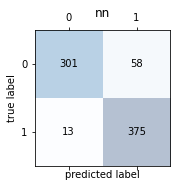

In [32]:
from sklearn.metrics import confusion_matrix

y_val = ans
y_pred = pred

confmat = confusion_matrix(y_true=y_val, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('predicted label')        
plt.ylabel('true label')
plt.title('nn')
plt.show()

觀察預測結果分佈

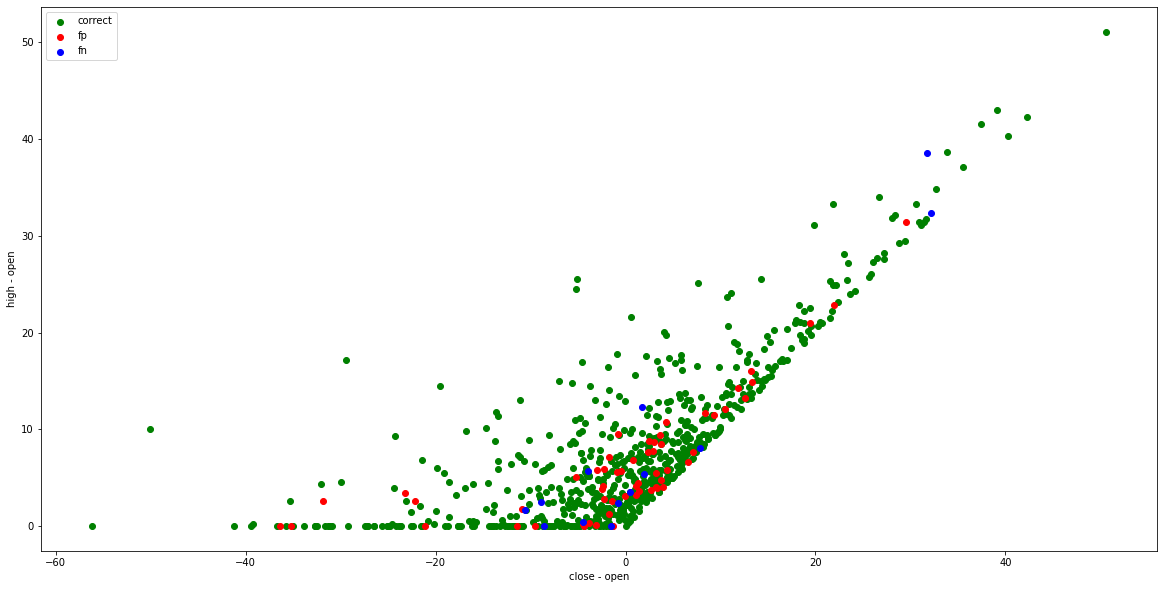

In [33]:
plt.figure(figsize=(20,10))

x = X_val['Close - Open']
y = X_val['High - Open']

x1 = [ i for (i, j, k) in zip(x, y_val, y_pred) if j == k ]
y1 = [ i for (i, j, k) in zip(y, y_val, y_pred) if j == k ]
x2 = [ i for (i, j, k) in zip(x, y_val, y_pred)  if j != k and k==1]
y2 = [ i for (i, j, k) in zip(y, y_val, y_pred)  if j != k and k==1]
x3 = [ i for (i, j, k) in zip(x, y_val, y_pred)  if j != k and k==0]
y3 = [ i for (i, j, k) in zip(y, y_val, y_pred)  if j != k and k==0]


plt.scatter(x1, y1, c='g', label='correct')  
plt.scatter(x2, y2, c='r', label='fp')
plt.scatter(x3, y3, c='b', label='fn')
plt.xlabel('close - open')
plt.ylabel('high - open')
plt.legend()
plt.show()  

### 查看 test set  結果

#### Logistic Regression
在 Validation 上的正確率高達 93% 但在這裡只有 82% ，可以發現 overfitting 了

In [34]:
test_df = pd.read_csv('../test.csv')
test_X = pd.DataFrame({
    'Close - Open': test_df['Close Price'][1:] - test_df['Open Price'][1:],
    'High - Open': test_df['High Price'][1:] - test_df['Open Price'][1:],
    'Open - Low': test_df['Open Price'][1:] - test_df['Low Price'][1:],
})
test_Y = [ 1 if (test_df['Close Price'][i+1] - test_df['Close Price'][i]) > 0 else 0 for i in range(len(test_df['High Price']) - 1)]
y_pred = clf.predict(test_X)

print(clf.score(test_X, test_Y))


0.8247011952191236


#### Other Classfication Model
同上，一樣也 overfitting 了

In [35]:
for m in other_models:
    y_pred = m.predict(test_X)

    print(m.score(test_X, test_Y))

0.8247011952191236
0.8247011952191236


#### Nenural Network
在 Validation Set 上的正確率高達 89% ，但在這裡只有 83% ，同樣也 overfitting

In [36]:
tmp = [ (test_X['Close - Open'].tolist()[i], test_X['High - Open'].tolist()[i], test_X['Open - Low'].tolist()[i], test_Y[i]) for i in range(len(test_Y))]
test_dataset = MyDataset(tmp)

test_data_loader = DataLoader(          # 創造 DataLoader 實例
    test_dataset,                       # 對資料集 test_dataset 進行抽樣
    batch_size=batch_size,              # 設定每次抽樣的數量
    shuffle=True,                       # 設定隨機抽樣
    collate_fn=collate_fn               # 指定格式化的方法
)

pred = []
ans = []

for batch_x, batch_y in test_data_loader:
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    ans.extend(batch_y)
    
    pred_y = model(batch_x.float())
    pred.extend(pred_y)
    
pred = [1 if i > 0.5 else 0 for i in pred]
ans  = [1 if i > 0.5 else 0 for i in ans]

correct = sum([1 if i == j else 0 for (i , j) in zip(pred, ans)])

print(correct/len(ans))

0.8326693227091634


/Users/0210amy/Desktop/school/schoolwork/data_analystic/FDA_HW3/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


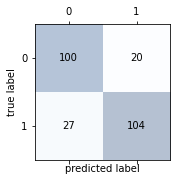

In [32]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=test_Y, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(2.5, 2.5))

ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('predicted label')        
plt.ylabel('true label')
plt.show()